In [7]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

#.py
from core import qlearning as q
from core import best_response_grid as br
from core import prices as pr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
class Agent:

    def __init__(self, nb_players=2, alpha=0.125, beta=10**(-5), delta=0.95, pN=None, pC=None, binary_demand=False, doubleQ=False):
        self.m = 3
        self.n = nb_players
        self.k = 1
        self.binary_demand = binary_demand
        if pN == None or pC == None:
            self.pC, self.pN = self._get_prices()
        else:
            self.pC, self.pN = pC, pN
        self.Xi = 0
        self.p1 = self.pN-self.Xi*(self.pC-self.pN)
        self.pm = self.pC+self.Xi*(self.pC-self.pN)
        self.A = np.zeros(self.m)
        for i in range(self.m):
            self.A[i] = self.p1 + i*(self.pm-self.p1)/(self.m-1)

        # combinations = itertools.product(self.A, repeat=self.n)
        # self.S = [list(combination) for combination in combinations]

        self.doubleQ = doubleQ

        if self.doubleQ:
            self.Q1 = np.random.uniform(size=(self.m, self.m**(self.n*self.k)),
                                        low=-0.5,
                                        high=0.5)

            self.Q2 = np.random.uniform(size=(self.m, self.m**(self.n*self.k)),
                                        low=-0.5,
                                        high=0.5)

        else:
            self.Q = np.random.uniform(size=(self.m, self.m**(self.n*self.k)),
                                       low=-0.5,
                                       high=0.5)

        self.epsilon = 1
        self.alpha = alpha
        self.beta = beta
        self.delta = delta
        self.t = 0

        self.find_ind = {self.A[i]: chr(i + 65) for i in range(len(self.A))}

        # On veut dans un certain sens que l'index soit complémentaire pour tous les joueurs
        self.s_ind = None
        self.s_t = None
        self.a_ind = None
        self.p = None
        self.s_ind1 = None
        self.s_t1 = None

        # When we want to stop when it convergs
        self.past_pairs = {}
        self.done = False
        self.cnt = 0

    def _get_prices(self):
        prices = pr.PriceOptimizer(
            nb_players=self.n, binary_demand=self.binary_demand)
        collusion_price, nash_price = prices()
        return collusion_price, nash_price

    def get_next_action(self):
        if self.doubleQ:
            Q = self.Q1 + self.Q2
        else:
            Q = self.Q

        if np.random.random() < 1-self.epsilon:
            return Q[:, self.s_ind].argmax()
        else:
            return np.random.randint(self.m)

    def _get_reward(self, q, p, c):
        return (p-c)*q

    def updateQ(self, p, q, c, t):  # upateQ
        reward = self._get_reward(q, p, c)

        if self.doubleQ:
            if np.random.random() < 0.5:
                self.Q1[self.a_ind, self.s_ind] = (1-self.alpha)*self.Q1[self.a_ind, self.s_ind] + self.alpha*(
                    reward + self.delta*self.Q2[self.Q1[:, self.s_ind1].argmax(), self.s_ind1])
            else:
                self.Q2[self.a_ind, self.s_ind]
        else:
            self.Q[self.a_ind, self.s_ind] = (
                1-self.alpha)*self.Q[self.a_ind, self.s_ind] + self.alpha*(reward + self.delta*self.Q[:, self.s_ind1].max())
        # print("Start")
        # print(reward)
        # print(self.Q[self.a_ind, self.s_ind1].max())
        # print(self.delta)
        # print(self.alpha)

        self.p = self.A[self.a_ind]
        # self.s_t = self.s_t1
        self.s_ind = self.s_ind1
        self.epsilon = np.exp(-self.beta*t)

    def find_index(self, s_t):
        strongstring = ''.join(
            [str(self.find_ind.get(price, '')) for price in s_t])
        s_ind = sum((ord(char) - 65) * (self.m ** (self.n - 1 - i))
                    for i, char in enumerate(strongstring))
        return s_ind

    def final_state(self, iterat=10**5):
        if self.done == False:
            if self.s_ind in self.past_pairs and self.past_pairs[self.s_ind] == self.a_ind:
                self.cnt += 1

            else:
                self.cnt = 0
                self.past_pairs[self.s_ind] = self.a_ind

            if self.cnt >= iterat:
                self.done = True


In [18]:
agents = [Agent() for _ in range(2)]
env = q.Env()

In [20]:
times = []
rewards = []
epsilon = []
prices = []
final_q_matrices = []
time_data = []

# Initialization of prices p0 (done directly in each agent)
for agent in agents:
    agent.p = np.random.choice(agent.A)

# Initialization of state
s_t = env([agent.p for agent in agents])[1]
for agent in agents:
    agent.s_t = s_t
s_ind = agents[0].find_index(agents[0].s_t)
for agent in agents:
    agent.s_ind = s_ind

t = 0
done_forall = False
# Iterative phase
while not done_forall:
    if t >= 10**6:
        break
    
    if t % (2*(10**5)) == 0:
        inter_start = time.time()
        print("t:", t)
        
        
    # Actions and state at t+1
    nb_done = 0
    for agent in agents:
        agent.a_ind = agent.get_next_action()
        # check here if the same action was taken in the past for the same state:
        agent.final_state()
        if agent.done == True:
                nb_done += 1
        if nb_done == len(agents):
                done_forall = True

    s_t1 = env([agent.A[agent.a_ind] for agent in agents])[1]
    for agent in agents:
        agent.s_t1 = s_t1
        
    s_ind1 = agents[0].find_index(agents[0].s_t1)
    for agent in agents:
        agent.s_ind1 = s_ind1

    times.append(t)
    ret = env(s_t1)
    quant, price, cost = ret

    re = ret[0]*ret[1]-ret[0]*ret[2]
    rewards.append(re)
    epsilon_values = [agent.epsilon for agent in agents]
    epsilon.append(epsilon_values)
    prices.append([agent.p for agent in agents])

    for i, agent in enumerate(agents):
        agent.updateQ(q=quant[i], p=price[i], c=cost[i], t=t)
        
    if t % (2*(10**5)) == 0:
        inter_end = time.time()
        time_data.append(inter_end-inter_start)
        print('average CPU', np.mean(time_data))


aggregated_agents = np.array(rewards).mean(axis=0)

for agent in agents:
    final_q_matrices.append(agent.Q.copy()) # retrieve the matrix

1


Rewards: [array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388])]
Prices: [[1.6974824430448874, 1.6974824430448874], [1.6974824430448874, 1.6974824430448874], [1.6974824430448874, 1.6974824430448874], [1.6974824430448874, 1.6974824430448874], [1.6974824430448874, 1.6974824430448874], [1.6974824430448874, 1.6974824430448874], [1.6974824430448874, 1.6974824430448874], [1.6974824430448874, 1.6974824430448874], [1.6974824430448874, 1.6974824430448874], [1.6974824430448874, 1.6974824430448874], [1.6974824430448874, 1.6974824430448874], [1.6974824430448874, 1.6

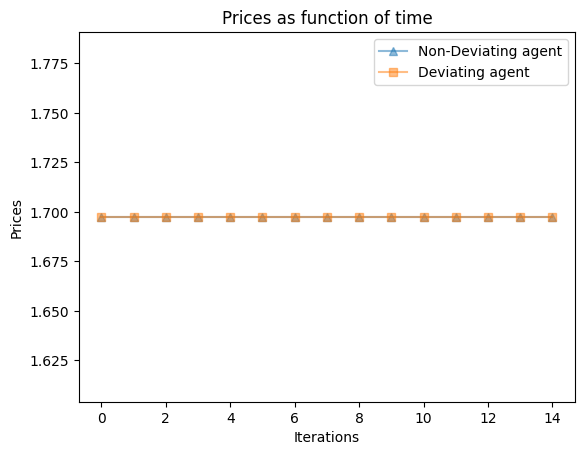

In [55]:
game_rewards = []

rewards = []  # Store rewards for each game simulation step
prices = []
    
# Game simulation
for t in range(15):  # Change the number of steps if necessary
    # Agents' actions (deterministic policy)
    for agent in agents:
        agent.a_ind = agent.Q[:, agent.s_ind].argmax() # This changes, we no longer use epsilon-greedy 
        
    # Next state and reward
    s_t1 = env([agent.A[agent.a_ind] for agent in agents])[1]
    ret = env(s_t1)
    quant, price, cost = ret

    re = ret[0]*ret[1]-ret[0]*ret[2]
    rewards.append(re)
    prices.append(price)
        
    # Update state for the next step
    s_t = s_t1
    for agent in agents:
        agent.s_t = s_t
    s_ind1 = agents[0].find_index(s_t1)
    for agent in agents:
        agent.s_ind1 = s_ind1
    
    for i, agent in enumerate(agents):
        agent.updateQ(q=quant[i], p=price[i], c=cost[i], t=t)
    

print(f"Rewards: {rewards}")
print(f"Prices: {prices}")

non_dev_p = []
dev_p = []
for i in range(len(prices)):
    non_dev_p.append(prices[i][0])
    dev_p.append(prices[i][1])
plt.plot(range(len(prices)),non_dev_p, label=f"Non-Deviating agent", marker='^',alpha=0.5)
plt.plot(range(len(prices)), dev_p, label=f"Deviating agent", marker='s', alpha=0.5)

plt.xlabel("Iterations")
plt.ylabel("Prices")
plt.title("Prices as function of time")
plt.legend()
plt.show()

## Deviating agent increases its price

Rewards: [array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.41010797, 0.21893374]), array([0.22169481, 0.22169481]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388])]
Prices: [[1.6974824430448874, 1.6974824430448874], [1.6974824430448874, 1.6974824430448874], [1.6974824430448874, 1.6974824430448874], [1.6974824430448874, 1.6974824430448874], [1.6974824430448874, 1.6974824430448874], [1.6974824430448874, 1.6974824430448874], [1.6974824430448874, 1.6974824430448874], [1.6974824430448874, 1.6974824430448874], [1.6974824430448874, 1.6974824430448874], [1.6974824430448874, 1.9249648860897746], [1.4700000000000004, 1.4700000000000004], [1.6974824430448874, 1.6

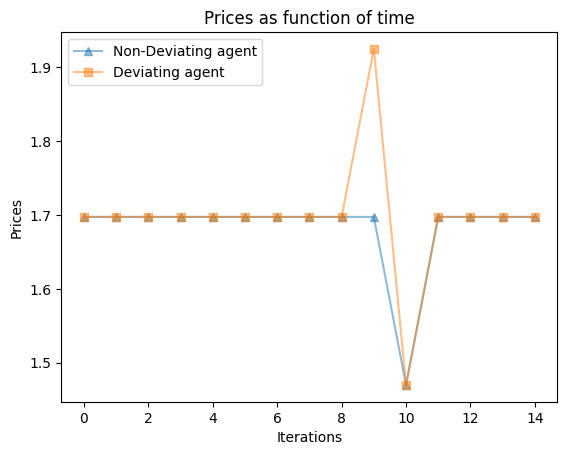

In [54]:
game_rewards = []

rewards = []  # Store rewards for each game simulation step
prices = []
    
# Game simulation
for t in range(15):  # Change the number of steps if necessary
    if t == 9: 
        # Agents' actions (deterministic policy)
        agents[0].a_ind = agents[0].Q[:, agents[0].s_ind].argmax() # This changes, we no longer use epsilon-greedy 
        agents[1].a_ind = 2 #increases its price
        
        # Next state and reward
        s_t1 = env([agent.A[agent.a_ind] for agent in agents])[1]
        ret = env(s_t1)
        quant, price, cost = ret

        re = ret[0]*ret[1]-ret[0]*ret[2]
        rewards.append(re)
        prices.append(price)
        
        # Update state for the next step
        s_t = s_t1
        for agent in agents:
            agent.s_t = s_t
        s_ind1 = agents[0].find_index(s_t1)
        for agent in agents:
            agent.s_ind1 = s_ind1
    
        for i, agent in enumerate(agents):
            agent.updateQ(q=quant[i], p=price[i], c=cost[i], t=t)
        
    else:
        # Agents' actions (deterministic policy)
        for agent in agents:
            agent.a_ind = agent.Q[:, agent.s_ind].argmax() # This changes, we no longer use epsilon-greedy 
        
        # Next state and reward
        s_t1 = env([agent.A[agent.a_ind] for agent in agents])[1]
        ret = env(s_t1)
        quant, price, cost = ret

        re = ret[0]*ret[1]-ret[0]*ret[2]
        rewards.append(re)
        prices.append(price)
        
        # Update state for the next step
        s_t = s_t1
        for agent in agents:
            agent.s_t = s_t
        s_ind1 = agents[0].find_index(s_t1)
        for agent in agents:
            agent.s_ind1 = s_ind1
    
        for i, agent in enumerate(agents):
            agent.updateQ(q=quant[i], p=price[i], c=cost[i], t=t)
    

print(f"Rewards: {rewards}")
print(f"Prices: {prices}")

non_dev_p = []
dev_p = []
for i in range(len(prices)):
    non_dev_p.append(prices[i][0])
    dev_p.append(prices[i][1])
plt.plot(range(len(prices)),non_dev_p, label=f"Non-Deviating agent", marker='^',alpha=0.5)
plt.plot(range(len(prices)), dev_p, label=f"Deviating agent", marker='s', alpha=0.5)

plt.xlabel("Iterations")
plt.ylabel("Prices")
plt.title("Prices as function of time")
plt.legend()
plt.show()

## Deviating agent decreases its price

In [52]:
game_rewards = []

rewards = []  # Store rewards for each game simulation step
prices = []
    
# Game simulation
for t in range(15):  # Change the number of steps if necessary
    if t == 9: 
        # Agents' actions (deterministic policy)
        agents[0].a_ind = agents[0].Q[:, agents[0].s_ind].argmax() # This changes, we no longer use epsilon-greedy 
        agents[1].a_ind = 0 #decreases its price
        
        # Next state and reward
        s_t1 = env([agent.A[agent.a_ind] for agent in agents])[1]
        ret = env(s_t1)
        quant, price, cost = ret

        re = ret[0]*ret[1]-ret[0]*ret[2]
        rewards.append(re)
        prices.append(price)
        
        # Update state for the next step
        s_t = s_t1
        for agent in agents:
            agent.s_t = s_t
        s_ind1 = agents[0].find_index(s_t1)
        for agent in agents:
            agent.s_ind1 = s_ind1
    
        for i, agent in enumerate(agents):
            agent.updateQ(q=quant[i], p=price[i], c=cost[i], t=t)
        
    else:
        # Agents' actions (deterministic policy)
        for agent in agents:
            agent.a_ind = agent.Q[:, agent.s_ind].argmax() # This changes, we no longer use epsilon-greedy 
        
        # Next state and reward
        s_t1 = env([agent.A[agent.a_ind] for agent in agents])[1]
        ret = env(s_t1)
        quant, price, cost = ret

        re = ret[0]*ret[1]-ret[0]*ret[2]
        rewards.append(re)
        prices.append(price)
        
        # Update state for the next step
        s_t = s_t1
        for agent in agents:
            agent.s_t = s_t
        s_ind1 = agents[0].find_index(s_t1)
        for agent in agents:
            agent.s_ind1 = s_ind1
    
        for i, agent in enumerate(agents):
            agent.updateQ(q=quant[i], p=price[i], c=cost[i], t=t)
    

print(f"Rewards: {rewards}")
print(f"Prices: {prices}")

non_dev_p = []
dev_p = []
for i in range(len(prices)):
    non_dev_p.append(prices[i][0])
    dev_p.append(prices[i][1])
plt.plot(range(len(prices)),non_dev_p, label=f"Non-Deviating agent", marker='^',alpha=0.5)
plt.plot(range(len(prices)), dev_p, label=f"Deviating agent", marker='s', alpha=0.5)

plt.xlabel("Iterations")
plt.ylabel("Prices")
plt.title("Prices as function of time")
plt.legend()
plt.show()

Rewards: [array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.18440577, 0.30868574]), array([0.22169481, 0.22169481]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388]), array([0.30349388, 0.30349388])]
Prices: [[1.6974824430448874, 1.6974824430448874], [1.6974824430448874, 1.6974824430448874], [1.6974824430448874, 1.6974824430448874], [1.6974824430448874, 1.6974824430448874], [1.6974824430448874, 1.6974824430448874], [1.6974824430448874, 1.6974824430448874], [1.6974824430448874, 1.6974824430448874], [1.6974824430448874, 1.6974824430448874], [1.6974824430448874, 1.6974824430448874], [1.6974824430448874, 1.4700000000000004], [1.4700000000000004, 1.4700000000000004], [1.6974824430448874, 1.6